In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.api.types import CategoricalDtype
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt 
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
ncl_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ncl_data.csv")

In [21]:
ncl_data

,Variable,Timestamp,Value,Location (WKT)
0,PM10,2019-07-01 00:00:00,5.424667,POINT (-1.619756 55.006886)
1,NO2,2019-07-01 00:00:00,37.107745,POINT (-1.618759 54.975987)
2,NO2,2019-07-01 00:00:00,24.373197,POINT (-1.626511 54.975625)
3,NO2,2019-07-01 00:00:00,22.826654,POINT (-1.621425 55.012202)
4,NO2,2019-07-01 00:00:00,19.419922,POINT (-1.61731 54.97226)
...,...,...,...,...
1476396,PM10,2020-06-30 23:00:00,2.250000,POINT (-1.606514 54.973793)
1476397,PM10,2020-06-30 23:00:00,5.938268,POINT (-1.553981 54.951477)
1476398,PM10,2020-06-30 23:00:00,5.197018,POINT (-1.58199 54.984003)
1476399,PM10,2020-06-30 23:00:00,3.308393,POINT (-1.558721 54.996494)


In [22]:
#PM10 data of NCL
ncl_pm10 = ncl_data.loc[ncl_data['Variable'] == 'PM10']
ncl_pm10 = ncl_pm10.drop('Variable', 1)
ncl_pm10 = ncl_pm10.drop('Location (WKT)', 1)
ncl_pm10

,Timestamp,Value
0,2019-07-01 00:00:00,5.424667
120,2019-07-01 00:00:00,6.486818
121,2019-07-01 00:00:00,6.055509
122,2019-07-01 00:00:00,1.613333
123,2019-07-01 00:00:00,1.176667
...,...,...
1476396,2020-06-30 23:00:00,2.250000
1476397,2020-06-30 23:00:00,5.938268
1476398,2020-06-30 23:00:00,5.197018
1476399,2020-06-30 23:00:00,3.308393


In [23]:
ncl_pm10_df = ncl_pm10[(ncl_pm10['Timestamp'] <= '2019-12-31 23:00:00	')]
ncl_pm10_df

,Timestamp,Value
0,2019-07-01 00:00:00,5.424667
120,2019-07-01 00:00:00,6.486818
121,2019-07-01 00:00:00,6.055509
122,2019-07-01 00:00:00,1.613333
123,2019-07-01 00:00:00,1.176667
...,...,...
698987,2019-12-31 23:00:00,28.544643
698988,2019-12-31 23:00:00,12.733750
698989,2019-12-31 23:00:00,18.132911
698990,2019-12-31 23:00:00,27.557500


In [24]:
df_pm10 = ncl_pm10_df.rename(columns = {"Timestamp":"ds","Value":"y"}) 
df_pm10['day'] = pd.to_datetime(df_pm10['ds']).dt.date
df_pm10 = df_pm10.groupby(["day"])['y'].mean().reset_index()
df_pm10 = df_pm10.rename(columns = {"day":"ds"}) 
df_pm10

,ds,y
0,2019-07-01,4.399093
1,2019-07-02,5.884503
2,2019-07-03,6.050297
3,2019-07-04,9.317409
4,2019-07-05,6.963904
...,...,...
149,2019-12-27,20.774130
150,2019-12-28,21.141221
151,2019-12-29,8.749873
152,2019-12-30,8.699011


In [34]:
## complete FB_Prophet fitting, plotting ETS components from model, finding performance metrics using cross validation and returing horizon based cross validation metrics on 
## a single training dataset -  cross validated on testing data only
def predict_FB_step1(df,break_index, per):
    df_FB = df[:break_index]
    print('start and end date of training dataset :', df_FB['ds'].head(1),df_FB['ds'].tail(1))
    
    test = df[break_index:break_index+per]
    print('start and end date of testing dataset :', test['ds'].head(1),test['ds'].tail(1))  
    print(test)
    
    from fbprophet import Prophet
    #The Prophet class (model)
    fbp = Prophet(daily_seasonality = True) 
    #Fit the model 
    fbp.fit(df_FB)
    
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    fut = fbp.make_future_dataframe(periods=per) 
    forecast = fbp.predict(fut)
    
    from fbprophet.plot import plot_plotly, plot_components_plotly
    # A better plot than the simple matplotlib
    forecast_plot = plot_plotly(fbp, forecast)
    forecast_plot.show()
    
    fbp.plot(forecast)
    plt.title("Prediction of air quality")
    plt.xlabel("Date")
    plt.ylabel("value")
    plt.show()
    
    fbp.plot_components(forecast)
    plt.show()
    
    from statsmodels.tools.eval_measures import rmse
    predictions = forecast.tail(per)
    
    #predictions = forecast.iloc[-per:]['yhat']
    print(predictions['yhat'],test['y'])
    

    
    
    # Plot predictions against known values
    import matplotlib.ticker as ticker
    #formatter = ticker.StrMethodFormatter('{x:,.0f}')
    title = 'Air Quality forecast of PM10 using FB Prophet'
    ylabel='Value'
    xlabel='Total days'
    ax = test['y'].plot(legend=True,figsize=(12,6),title=title)
    predictions['yhat'].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    #ax.yaxis.set_major_formatter(formatter);
    
    from fbprophet.diagnostics import cross_validation,performance_metrics
    from fbprophet.plot import plot_cross_validation_metric
    
    length = round(len(df_FB)/24,0)
    print(length)
    
    # Initial length of df_FB training period
    initial = 80
    initial = str(initial) + ' days'
    # Fold every length of df_FB years
    period = 10
    period = str(period) + ' days'
    # Forecast per days into the future
    horizon = per
    horizon = str(horizon) + ' days'
    #, 
    df_cv = cross_validation(fbp,initial=initial, period=period,  horizon = horizon)
    df_cv
    performance_metrics = performance_metrics(df_cv)
    print(performance_metrics)
    
    plot_cross_validation_metric(df_cv, metric='rmse');
    plt.title("rmse metric")
    plt.show()
    
    plot_cross_validation_metric(df_cv, metric='mape');
    plt.title("mape metric")
    plt.show()
    performance_metrics.to_csv("performance_metrics_pm10_ncl.csv") 
    !cp performance_metrics_pm10_ncl.csv "/content/drive/MyDrive/Colab Notebooks"
    return performance_metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


start and end date of training dataset : 0    2019-07-01
Name: ds, dtype: object 122    2019-10-31
Name: ds, dtype: object
start and end date of testing dataset : 123    2019-12-01
Name: ds, dtype: object 153    2019-12-31
Name: ds, dtype: object
             ds          y
123  2019-12-01   9.625648
124  2019-12-02   6.475536
125  2019-12-03  11.499681
126  2019-12-04  10.038343
127  2019-12-05   5.249765
128  2019-12-06   4.941136
129  2019-12-07   5.007998
130  2019-12-08   6.685898
131  2019-12-09   7.902353
132  2019-12-10   7.919755
133  2019-12-11   8.144037
134  2019-12-12  18.256253
135  2019-12-13   6.707749
136  2019-12-14   7.518578
137  2019-12-15   7.209685
138  2019-12-16   6.473378
139  2019-12-17  14.867206
140  2019-12-18  26.737553
141  2019-12-19  13.111573
142  2019-12-20  12.018536
143  2019-12-21  20.351223
144  2019-12-22  48.814133
145  2019-12-23   9.563097
146  2019-12-24  16.268108
147  2019-12-25   5.921550
148  2019-12-26   8.938230
149  2019-12-27  20.7741

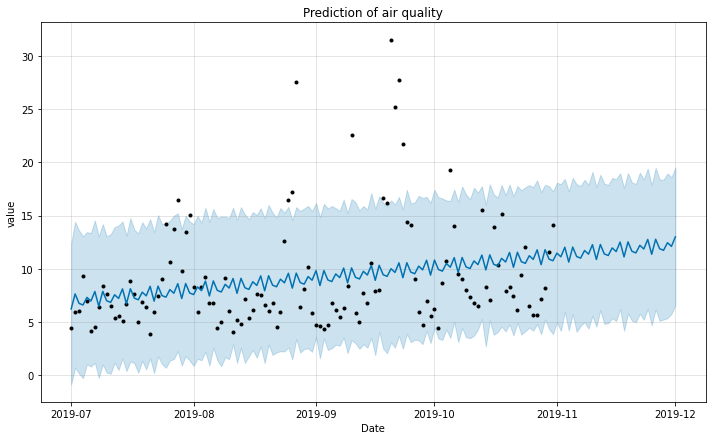

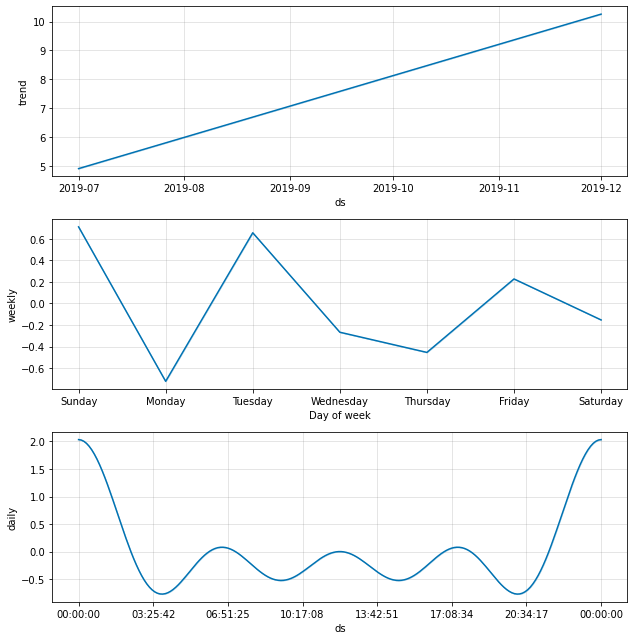

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-09-20 00:00:00 and 2019-09-30 00:00:00


123    11.469148
124    11.123885
125    12.022426
126    10.624049
127    12.037558
128    11.149753
129    10.997435
130    11.714072
131    11.368809
132    12.267350
133    10.868974
134    12.282483
135    11.394678
136    11.242359
137    11.958997
138    11.613734
139    12.512275
140    11.113898
141    12.527407
142    11.639603
143    11.487284
144    12.203921
145    11.858658
146    12.757199
147    11.358823
148    12.772332
149    11.884527
150    11.732208
151    12.448846
152    12.103583
153    13.002124
Name: yhat, dtype: float64 123     9.625648
124     6.475536
125    11.499681
126    10.038343
127     5.249765
128     4.941136
129     5.007998
130     6.685898
131     7.902353
132     7.919755
133     8.144037
134    18.256253
135     6.707749
136     7.518578
137     7.209685
138     6.473378
139    14.867206
140    26.737553
141    13.111573
142    12.018536
143    20.351223
144    48.814133
145     9.563097
146    16.268108
147     5.921550
148     8.938230
149 

  0%|          | 0/2 [00:00<?, ?it/s]

   horizon         mse       rmse        mae      mape     mdape  coverage
0   3 days  133.046470  11.534577  10.403657  0.837213  0.616784  0.166667
1   4 days   84.622680   9.199059   7.089663  0.570601  0.424678  0.500000
2   5 days   35.719150   5.976550   4.722836  0.289177  0.276818  0.666667
3   6 days   12.100571   3.478587   2.743747  0.187517  0.160883  0.833333
4   7 days   18.207467   4.267021   3.611696  0.354317  0.251672  0.666667
5   8 days   17.743762   4.212334   3.679466  0.550850  0.435474  0.833333
6   9 days   22.962288   4.791898   4.637127  0.695735  0.584160  0.833333
7  10 days   23.330684   4.830185   4.791615  0.734288  0.609233  1.000000
8  11 days   27.874680   5.279648   5.160294  0.777097  0.749621  0.833333
9  12 days   35.388349   5.948811   5.879291  0.992965  0.922417  0.666667
10 13 days   29.563532   5.437236   5.030379  0.807510  0.922417  0.666667
11 14 days   18.169510   4.262571   3.778162  0.573784  0.377871  0.833333
12 15 days   27.904333   

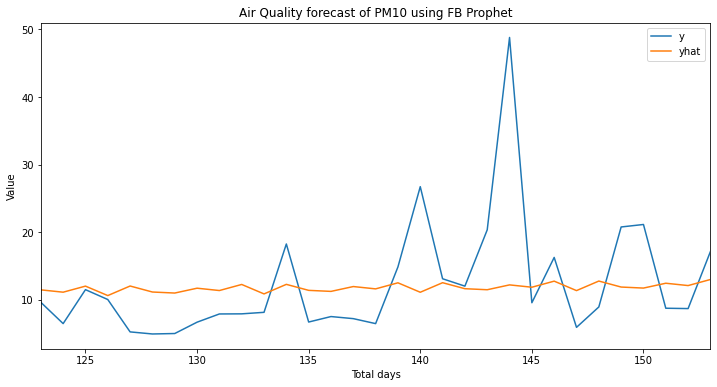

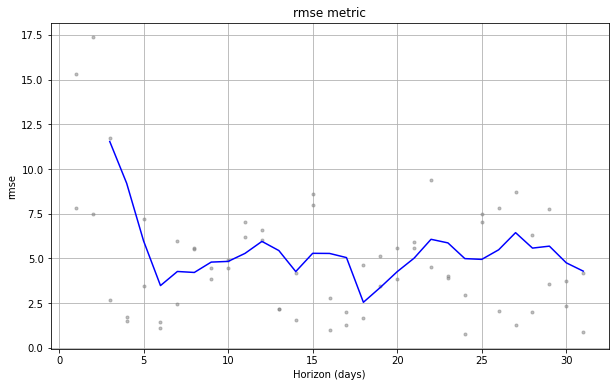

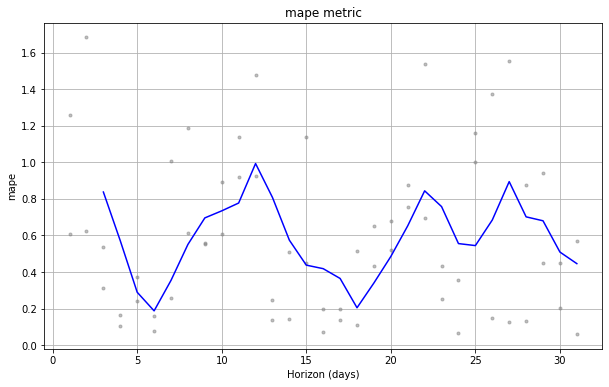

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,133.046470,11.534577,10.403657,0.837213,0.616784,0.166667
1,4 days,84.622680,9.199059,7.089663,0.570601,0.424678,0.500000
2,5 days,35.719150,5.976550,4.722836,0.289177,0.276818,0.666667
3,6 days,12.100571,3.478587,2.743747,0.187517,0.160883,0.833333
4,7 days,18.207467,4.267021,3.611696,0.354317,0.251672,0.666667
5,8 days,17.743762,4.212334,3.679466,0.550850,0.435474,0.833333
6,9 days,22.962288,4.791898,4.637127,0.695735,0.584160,0.833333
7,10 days,23.330684,4.830185,4.791615,0.734288,0.609233,1.000000
8,11 days,27.874680,5.279648,5.160294,0.777097,0.749621,0.833333
9,12 days,35.388349,5.948811,5.879291,0.992965,0.922417,0.666667


In [35]:
#PM10 prediction of NCL
predict_FB_step1(df_pm10,123,31)

In [28]:
#NO2 data of NCL
ncl_no2 = ncl_data.loc[ncl_data['Variable'] == 'NO2']
ncl_no2 = ncl_no2.drop('Variable', 1)
ncl_no2 = ncl_no2.drop('Location (WKT)', 1)
ncl_no2 = ncl_no2[(ncl_no2['Timestamp'] <= '2019-12-31 23:00:00')]
ncl_no2

,Timestamp,Value
1,2019-07-01 00:00:00,37.107745
2,2019-07-01 00:00:00,24.373197
3,2019-07-01 00:00:00,22.826654
4,2019-07-01 00:00:00,19.419922
5,2019-07-01 00:00:00,4.343427
...,...,...
699124,2019-12-31 23:00:00,27.883690
699125,2019-12-31 23:00:00,25.227093
699126,2019-12-31 23:00:00,45.459617
699127,2019-12-31 23:00:00,30.382868


In [29]:
df_no2 = ncl_no2.rename(columns = {"Timestamp":"ds","Value":"y"}) 
df_no2['day'] = pd.to_datetime(df_no2['ds']).dt.date
df_no2 = df_no2.groupby(["day"])['y'].mean().reset_index()
df_no2 = df_no2.rename(columns = {"day":"ds","Value":"y"}) 
df_no2

,ds,y
0,2019-07-01,37.451398
1,2019-07-02,42.853895
2,2019-07-03,45.311397
3,2019-07-04,48.689494
4,2019-07-05,31.780831
...,...,...
149,2019-12-27,38.868880
150,2019-12-28,41.694361
151,2019-12-29,30.840290
152,2019-12-30,30.283159


In [32]:
## complete FB_Prophet fitting, plotting ETS components from model, finding performance metrics using cross validation and returing horizon based cross validation metrics on 
## a single training dataset -  cross validated on testing data only
def predict_FB_step1(df,break_index, per):
    df_FB = df[:break_index]
    print('start and end date of training dataset :', df_FB['ds'].head(1),df_FB['ds'].tail(1))
    
    test = df[break_index:break_index+per]
    print('start and end date of testing dataset :', test['ds'].head(1),test['ds'].tail(1))  
    print(test)
    
    from fbprophet import Prophet
    #The Prophet class (model)
    fbp = Prophet(daily_seasonality = True) 
    #Fit the model 
    fbp.fit(df_FB)
    
    # We need to specify the number of days in future
    # We'll be predicting the full 2021 stock prices
    fut = fbp.make_future_dataframe(periods=per) 
    forecast = fbp.predict(fut)
    
    from fbprophet.plot import plot_plotly, plot_components_plotly
    # A better plot than the simple matplotlib
    forecast_plot = plot_plotly(fbp, forecast)
    forecast_plot.show()
    
    fbp.plot(forecast)
    plt.title("Prediction of air quality")
    plt.xlabel("Date")
    plt.ylabel("value")
    plt.show()
    
    fbp.plot_components(forecast)
    plt.show()
    
    from statsmodels.tools.eval_measures import rmse
    predictions = forecast.tail(per)
    
    #predictions = forecast.iloc[-per:]['yhat']
    print(predictions['yhat'],test['y'])
    

    
    
    # Plot predictions against known values
    import matplotlib.ticker as ticker
    #formatter = ticker.StrMethodFormatter('{x:,.0f}')
    title = 'Air Quality forecast of NO2 using FB Prophet'
    ylabel='Value'
    xlabel='Total days'
    ax = test['y'].plot(legend=True,figsize=(12,6),title=title)
    predictions['yhat'].plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    #ax.yaxis.set_major_formatter(formatter);
    
    from fbprophet.diagnostics import cross_validation,performance_metrics
    from fbprophet.plot import plot_cross_validation_metric
    
    length = round(len(df_FB)/24,0)
    print(length)
    
    # Initial length of df_FB training period
    initial = 80
    initial = str(initial) + ' days'
    # Fold every length of df_FB years
    period = 10
    period = str(period) + ' days'
    # Forecast per days into the future
    horizon = per
    horizon = str(horizon) + ' days'
    #, 
    df_cv = cross_validation(fbp,initial=initial, period=period,  horizon = horizon)
    df_cv
    performance_metrics = performance_metrics(df_cv)
    print(performance_metrics)
    
    plot_cross_validation_metric(df_cv, metric='rmse');
    plt.title("rmse metric")
    plt.show()
    
    plot_cross_validation_metric(df_cv, metric='mape');
    plt.title("mape metric")
    plt.show()
    performance_metrics.to_csv("performance_metrics_no2_ncl.csv") 
    !cp performance_metrics_no2_ncl.csv "/content/drive/MyDrive/Colab Notebooks"
    return performance_metrics

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


start and end date of training dataset : 0    2019-07-01
Name: ds, dtype: object 122    2019-10-31
Name: ds, dtype: object
start and end date of testing dataset : 123    2019-12-01
Name: ds, dtype: object 153    2019-12-31
Name: ds, dtype: object
             ds          y
123  2019-12-01  32.014462
124  2019-12-02  35.695491
125  2019-12-03  50.670385
126  2019-12-04  48.560518
127  2019-12-05  35.266027
128  2019-12-06  42.527799
129  2019-12-07  34.809772
130  2019-12-08  27.895626
131  2019-12-09  37.819193
132  2019-12-10  36.893611
133  2019-12-11  46.141695
134  2019-12-12  56.853098
135  2019-12-13  39.561003
136  2019-12-14  33.326926
137  2019-12-15  41.858765
138  2019-12-16  48.803194
139  2019-12-17  60.497133
140  2019-12-18  53.575945
141  2019-12-19  62.509249
142  2019-12-20  51.812311
143  2019-12-21  54.949711
144  2019-12-22  48.397788
145  2019-12-23  67.554863
146  2019-12-24  42.748325
147  2019-12-25  20.631021
148  2019-12-26  29.218405
149  2019-12-27  38.8688

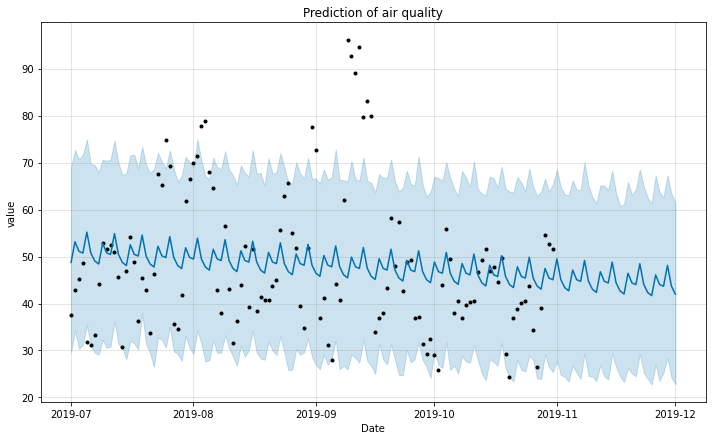

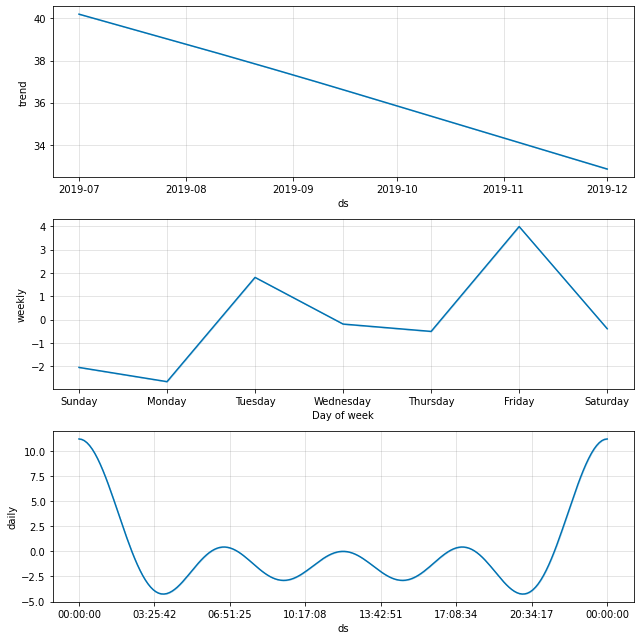

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-09-20 00:00:00 and 2019-09-30 00:00:00


123    49.501533
124    45.072446
125    43.363043
126    42.703859
127    47.125070
128    45.074483
129    44.710343
130    49.157109
131    44.728021
132    43.018618
133    42.359435
134    46.780646
135    44.730059
136    44.365919
137    48.812684
138    44.383597
139    42.674194
140    42.015010
141    46.436221
142    44.385634
143    44.021494
144    48.468260
145    44.039172
146    42.329769
147    41.670586
148    46.091797
149    44.041210
150    43.677070
151    48.123835
152    43.694748
153    41.985345
Name: yhat, dtype: float64 123    32.014462
124    35.695491
125    50.670385
126    48.560518
127    35.266027
128    42.527799
129    34.809772
130    27.895626
131    37.819193
132    36.893611
133    46.141695
134    56.853098
135    39.561003
136    33.326926
137    41.858765
138    48.803194
139    60.497133
140    53.575945
141    62.509249
142    51.812311
143    54.949711
144    48.397788
145    67.554863
146    42.748325
147    20.631021
148    29.218405
149 

  0%|          | 0/2 [00:00<?, ?it/s]

   horizon         mse       rmse        mae      mape     mdape  coverage
0   3 days  339.809539  18.433924  15.640410  0.482859  0.299137  0.666667
1   4 days  215.294545  14.672919  11.433567  0.329895  0.240915  0.833333
2   5 days  100.774744  10.038662   8.845164  0.190591  0.203818  1.000000
3   6 days  171.418586  13.092692  11.152043  0.265775  0.245210  0.833333
4   7 days  275.856057  16.608915  14.761438  0.376192  0.323380  0.666667
5   8 days  478.632441  21.877670  20.799296  0.580381  0.573567  0.333333
6   9 days  560.262495  23.669865  22.326583  0.656634  0.638337  0.333333
7  10 days  564.067253  23.750100  22.668667  0.682216  0.678792  0.333333
8  11 days  594.231839  24.376871  22.898322  0.700683  0.613826  0.500000
9  12 days  608.997134  24.677867  22.287275  0.712663  0.613826  0.500000
10 13 days  516.424528  22.724976  19.266300  0.602521  0.398636  0.666667
11 14 days  277.233073  16.650317  12.212895  0.360188  0.163270  0.833333
12 15 days  112.871937  1

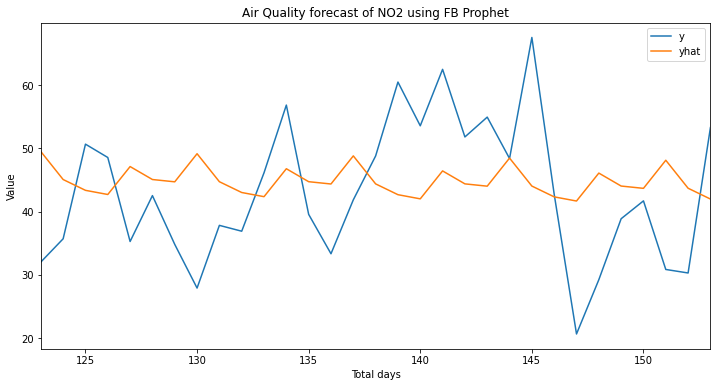

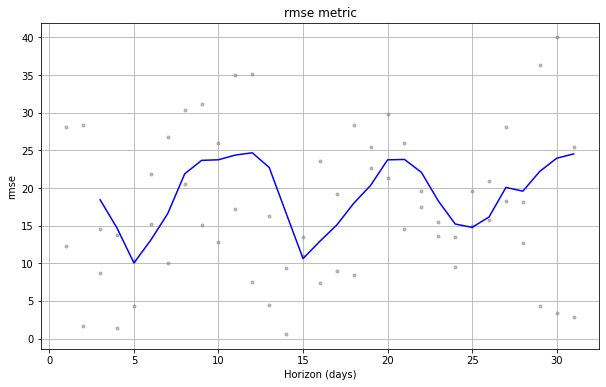

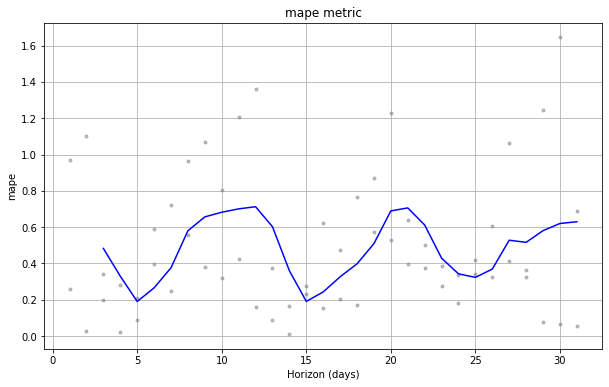

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,339.809539,18.433924,15.640410,0.482859,0.299137,0.666667
1,4 days,215.294545,14.672919,11.433567,0.329895,0.240915,0.833333
2,5 days,100.774744,10.038662,8.845164,0.190591,0.203818,1.000000
3,6 days,171.418586,13.092692,11.152043,0.265775,0.245210,0.833333
4,7 days,275.856057,16.608915,14.761438,0.376192,0.323380,0.666667
5,8 days,478.632441,21.877670,20.799296,0.580381,0.573567,0.333333
6,9 days,560.262495,23.669865,22.326583,0.656634,0.638337,0.333333
7,10 days,564.067253,23.750100,22.668667,0.682216,0.678792,0.333333
8,11 days,594.231839,24.376871,22.898322,0.700683,0.613826,0.500000
9,12 days,608.997134,24.677867,22.287275,0.712663,0.613826,0.500000


In [33]:
#NO2 prediction of NCL
predict_FB_step1(df_no2,123,31)

In [13]:
pf_metric_pm10 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/performance_metrics_pm10_ncl.csv")
pf_metric_pm10

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,coverage
0,0,2 days,20.636398,4.542730,4.166342,0.584449,0.448752,0.750000
1,1,3 days,27.645873,5.257934,4.868423,0.680657,0.608599,0.750000
2,2,4 days,39.301481,6.269089,6.062294,0.966527,0.852859,0.571429
3,3,5 days,29.040944,5.388965,4.970297,0.767541,0.580864,0.678571
4,4,6 days,12.565407,3.544772,3.057752,0.387459,0.264752,0.904762
5,5,7 days,20.555634,4.533832,3.969235,0.438855,0.352291,0.857143
6,6,8 days,25.946052,5.093727,4.398089,0.544966,0.352291,0.714286
7,7,9 days,24.748929,4.974830,4.049323,0.574232,0.352291,0.666667
8,8,10 days,23.468894,4.844470,4.181730,0.554681,0.361496,0.809524
9,9,11 days,24.173818,4.916688,4.688881,0.574842,0.620528,0.952381


In [14]:
pf_metric_pm10 = pf_metric_pm10.filter(['horizon','rmse','mape'], axis=1)
pf_metric_pm10['Variable'] = 'PM10'
pf_metric_pm10['City'] = 'NCL'
pf_metric_pm10

,horizon,rmse,mape,Variable,City
0,2 days,4.542730,0.584449,PM10,NCL
1,3 days,5.257934,0.680657,PM10,NCL
2,4 days,6.269089,0.966527,PM10,NCL
3,5 days,5.388965,0.767541,PM10,NCL
4,6 days,3.544772,0.387459,PM10,NCL
5,7 days,4.533832,0.438855,PM10,NCL
6,8 days,5.093727,0.544966,PM10,NCL
7,9 days,4.974830,0.574232,PM10,NCL
8,10 days,4.844470,0.554681,PM10,NCL
9,11 days,4.916688,0.574842,PM10,NCL


In [15]:
pf_metric_no2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/performance_metrics_no2_ncl.csv")
pf_metric_no2

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,coverage
0,0,2 days,321.312663,17.925196,16.511422,0.519708,0.269414,0.500000
1,1,3 days,312.706676,17.683514,15.943396,0.483509,0.364855,0.642857
2,2,4 days,333.503845,18.262088,15.679093,0.485106,0.303715,0.714286
3,3,5 days,222.366034,14.911943,11.711720,0.355284,0.235228,0.821429
4,4,6 days,87.260543,9.341335,7.060599,0.185393,0.188165,0.952381
5,5,7 days,41.115470,6.412135,5.897659,0.130121,0.119635,1.000000
6,6,8 days,112.549416,10.608931,8.927251,0.222642,0.188165,1.000000
7,7,9 days,196.574925,14.020518,12.215776,0.351705,0.324871,0.857143
8,8,10 days,215.330596,14.674147,12.791775,0.364902,0.324871,0.714286
9,9,11 days,233.522528,15.281444,13.258143,0.373666,0.194818,0.666667


In [16]:
pf_metric_no2 = pf_metric_no2.filter(['horizon','rmse','mape'], axis=1)
pf_metric_no2['Variable'] = 'NO2'
pf_metric_no2['City'] = 'NCL'
pf_metric_no2

,horizon,rmse,mape,Variable,City
0,2 days,17.925196,0.519708,NO2,NCL
1,3 days,17.683514,0.483509,NO2,NCL
2,4 days,18.262088,0.485106,NO2,NCL
3,5 days,14.911943,0.355284,NO2,NCL
4,6 days,9.341335,0.185393,NO2,NCL
5,7 days,6.412135,0.130121,NO2,NCL
6,8 days,10.608931,0.222642,NO2,NCL
7,9 days,14.020518,0.351705,NO2,NCL
8,10 days,14.674147,0.364902,NO2,NCL
9,11 days,15.281444,0.373666,NO2,NCL


In [17]:
pf_metric_ncl = pd.concat([pf_metric_no2, pf_metric_pm10])
pf_metric_ncl = pf_metric_ncl.reset_index()
pf_metric_ncl = pf_metric_ncl.drop('index', axis=1)
pf_metric_ncl

,horizon,rmse,mape,Variable,City
0,2 days,17.925196,0.519708,NO2,NCL
1,3 days,17.683514,0.483509,NO2,NCL
2,4 days,18.262088,0.485106,NO2,NCL
3,5 days,14.911943,0.355284,NO2,NCL
4,6 days,9.341335,0.185393,NO2,NCL
5,7 days,6.412135,0.130121,NO2,NCL
6,8 days,10.608931,0.222642,NO2,NCL
7,9 days,14.020518,0.351705,NO2,NCL
8,10 days,14.674147,0.364902,NO2,NCL
9,11 days,15.281444,0.373666,NO2,NCL


In [18]:
pf_metric_ncl.to_csv("pf_metric_ncl.csv") 
!cp pf_metric_ncl.csv "/content/drive/MyDrive/Colab Notebooks"